In [1]:
import torch
import torchvision
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
import numpy as np
from train import train
from models import ffn, load_resnet18
from dataset import MNIST_Dataset
from prune_fns import prune_model

In [2]:
device = torch.device("cuda:0" if (torch.cuda.is_available()) else "cpu")
model = ffn(784, 16, 10, device).to(device)

In [3]:
opt = torch.optim.Adam(model.parameters())
scheduler = None
crit = torch.nn.CrossEntropyLoss()
config = {
    'num_epoch' : 2,
    'lr' : 0.001,
    'beta1' : 0.9,
    'batch_size' : 32,
    'ckpt_path' : 'checkpoints/pruning_test/test/',
    'device' : device,
    'val_freq' : 1000,
    'opt' : opt,
    'scheduler' : scheduler, 
    'crit' : crit
}

dataset = MNIST_Dataset(config['batch_size'], dataset_path="./", device=config['device'], val=0.1)

In [4]:
def prune_modules_fn(model):
    # Define submodules to prune here
    # in a list format, each item is e.g. (module, "weight")
    return [(model.fc1, "weight"), 
            (model.fc2, "weight"), 
            (model.fc3, "weight")]

In [11]:
pct_weight_pruned = [1-0.8**i for i in range(20)]
test_acc = np.empty((5, 20))
for r in range(5):
    model = ffn(784, 32, 10, device).to(device)
    config['opt'] = torch.optim.Adam(model.parameters())
    results = train(config, dataset, model, save_weights_iter=0, params_to_save=prune_modules_fn, save_progress=False)
    
    test_acc[r, 0] = results[-2]
    for i in range(1,20):# prune p% weights from the model
        p = 0.2
        prune_model(model, p, prune_modules_fn, device)
        config['opt'] = torch.optim.Adam(model.parameters())
        results = train(config, dataset, model, save_weights_iter=0, params_to_save=prune_modules_fn, save_progress=False)
        pct_weight_pruned.append(1 - p ** i)
        test_acc[r][i] = results[-2]

0 0 0.12866666666666668 13844.717384338379 2.3659887313842773
1000 0 0.12866666666666668 13844.717384338379 2.3125666950370642
2000 1 0.12866666666666668 13844.717384338379 2.314537615821765
3000 1 0.12866666666666668 13844.717384338379 2.3131250639680863
0 0 0.1005 13832.058322906494 2.2751355171203613
1000 0 0.904 1947.2829586267471 0.9704318852215023
2000 1 0.921 1628.2458813786507 0.5686999094276763
3000 1 0.9361666666666667 1305.7425394654274 0.5629686947574347
0 0 0.09633333333333334 13970.154582977295 2.479971170425415
1000 0 0.89 2226.550569295883 1.0139813568744507
2000 1 0.9018333333333334 1981.6939760446548 0.6881187193500348
3000 1 0.9171666666666667 1732.5757735967636 0.6644176016054532
0 0 0.096 14751.10311126709 2.5649068355560303
1000 0 0.8935 2128.709209918976 0.986894360014966
2000 1 0.8893333333333333 2163.4148728847504 0.6840866190937761
3000 1 0.9163333333333333 1688.9456481337547 0.6584983667343152
0 0 0.096 16025.063217163086 2.7335903644561768
1000 0 0.898333333

In [ ]:
mean_test_acc = []

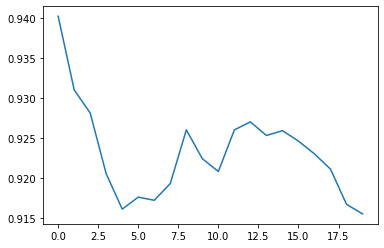

In [22]:
plt.plot(test_acc)
plt.show()

In [20]:
with torch.no_grad():
    count = 0
    nonzero_cnt = 0
    for param in model.parameters():
        if param.requires_grad:
            count += torch.numel(param)
            nonzero_cnt += torch.count_nonzero(param)
    print(count)
    print(nonzero_cnt)
    print(nonzero_cnt / count)

111146
tensor(2546, device='cuda:0')
tensor(0.0229, device='cuda:0')


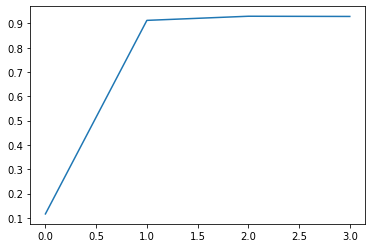

In [6]:
plt.plot(results[2])

In [7]:
results[-2]

0.939

In [18]:
np.mean(test_acc, axis=0)

array([0.10704, 0.93924, 0.92792, 0.92396, 0.91994, 0.91894, 0.91518,
       0.9173 , 0.91968, 0.91946, 0.92158, 0.92396, 0.92506, 0.92668,
       0.92546, 0.92348, 0.92404, 0.9212 , 0.9173 , 0.9125 ])

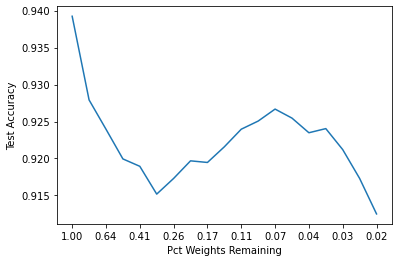

In [11]:
plt.plot(np.mean(test_acc, axis=0)[1:])
plt.xlabel("Pct Weights Remaining")
plt.ylabel("Test Accuracy")
plt.xticks(ticks=range(0,20,2), labels=["{:.2f}".format(0.8**i) for i in range(0, 20, 2)])
plt.show()

<ErrorbarContainer object of 3 artists>

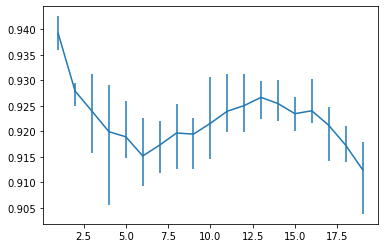

In [38]:
mean = np.mean(test_acc, axis=0)[1:]
maxm = np.max(test_acc, axis=0)[1:]
minm = np.min(test_acc, axis=0)[1:]
plt.errorbar([i for i in range(1,20)], mean, yerr=(mean-minm, maxm-mean), capthick=0.1)

In [40]:
np.save("ffn_pruning_acc_data", test_acc)

In [6]:
test_acc = np.load("ffn_pruning_acc_data.npy")